<a href="https://colab.research.google.com/github/sama-squareshift/chicago-taxi-trips/blob/main/chicago_taxi_trips.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


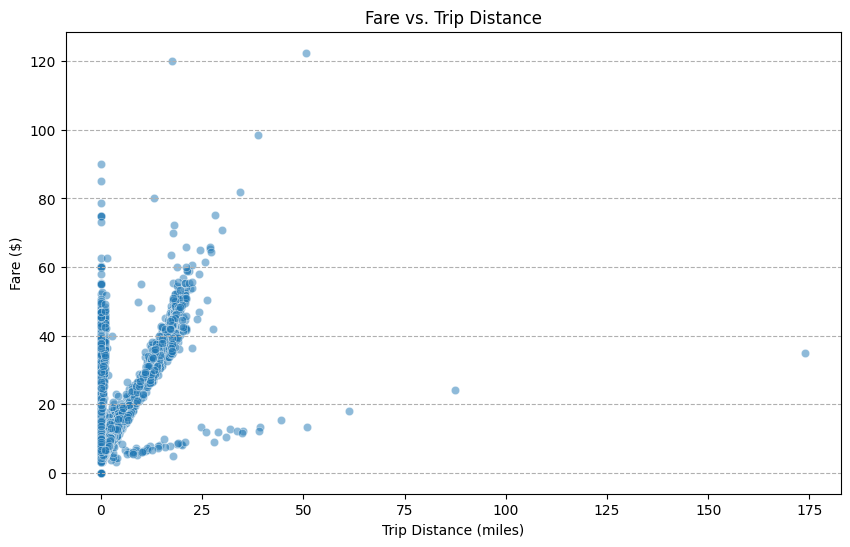

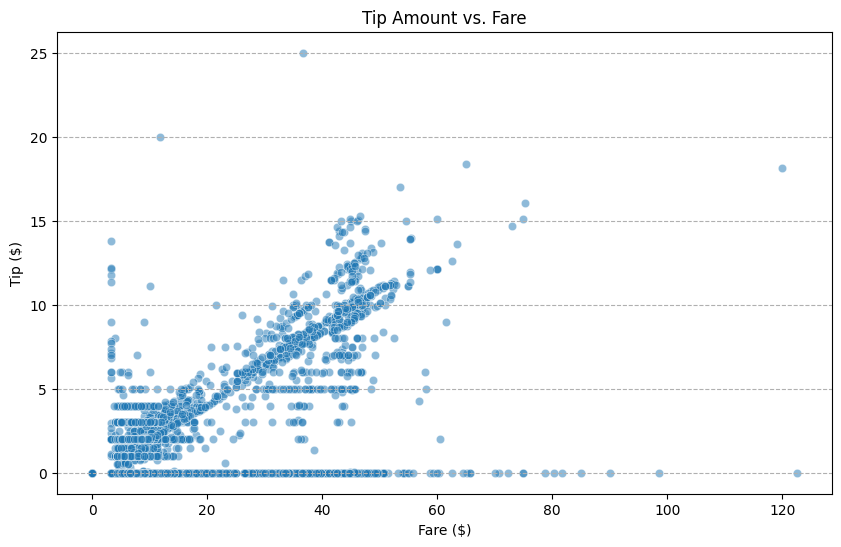

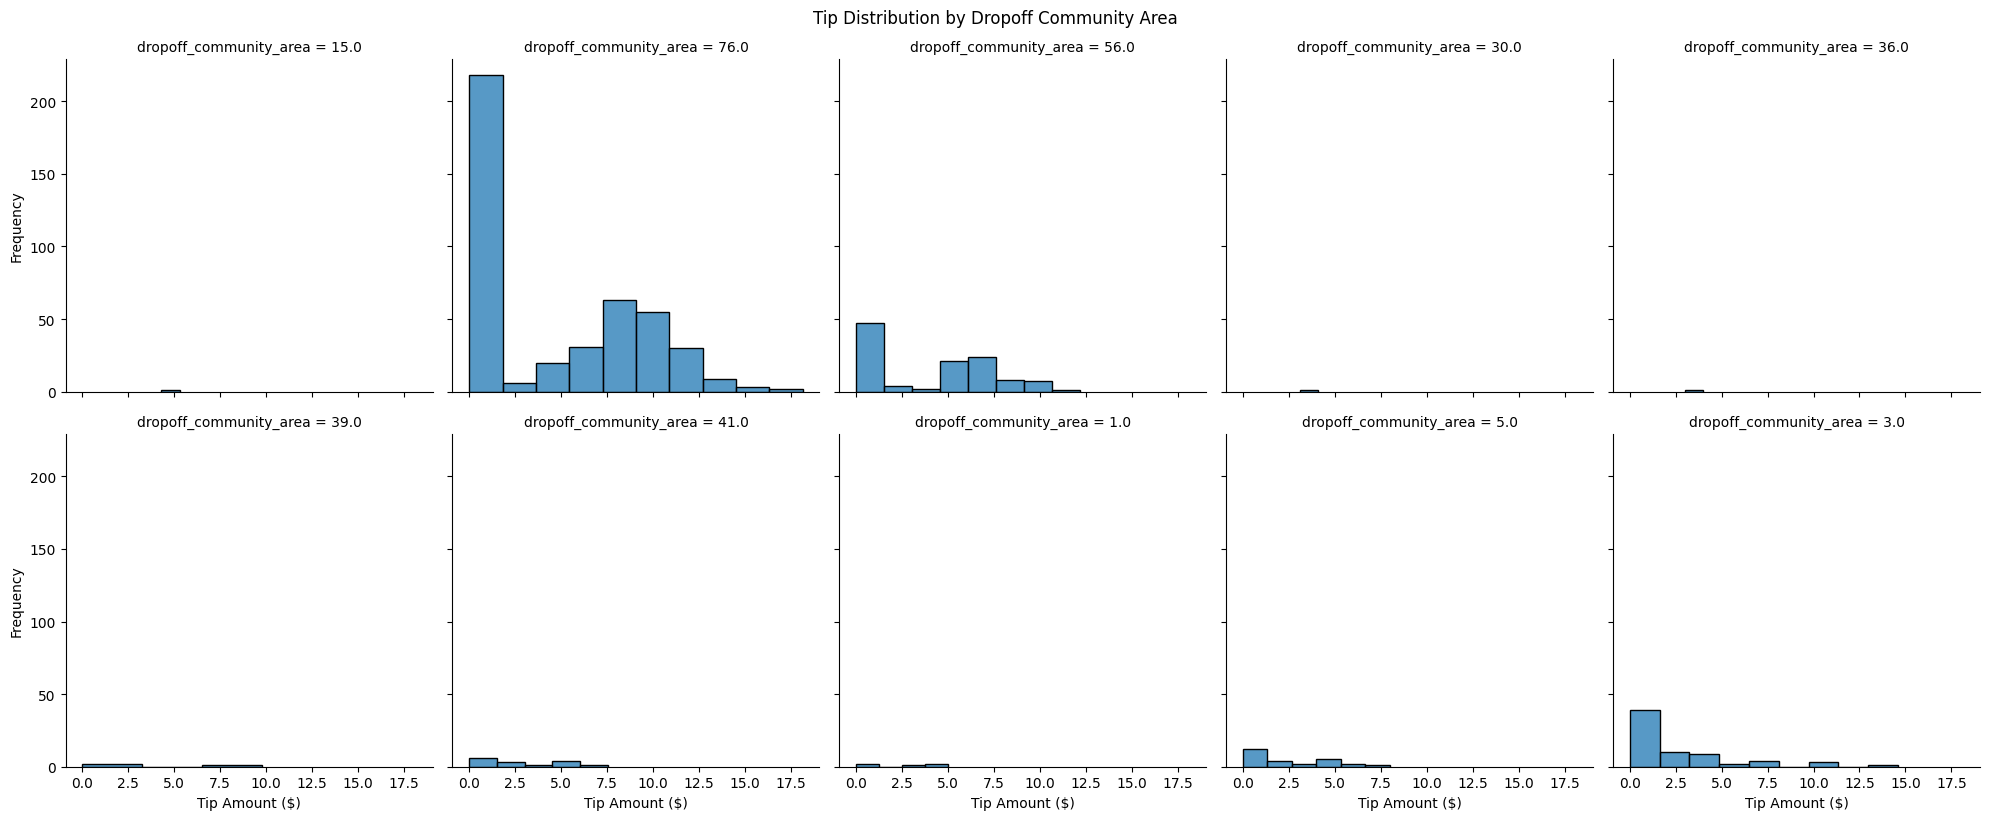

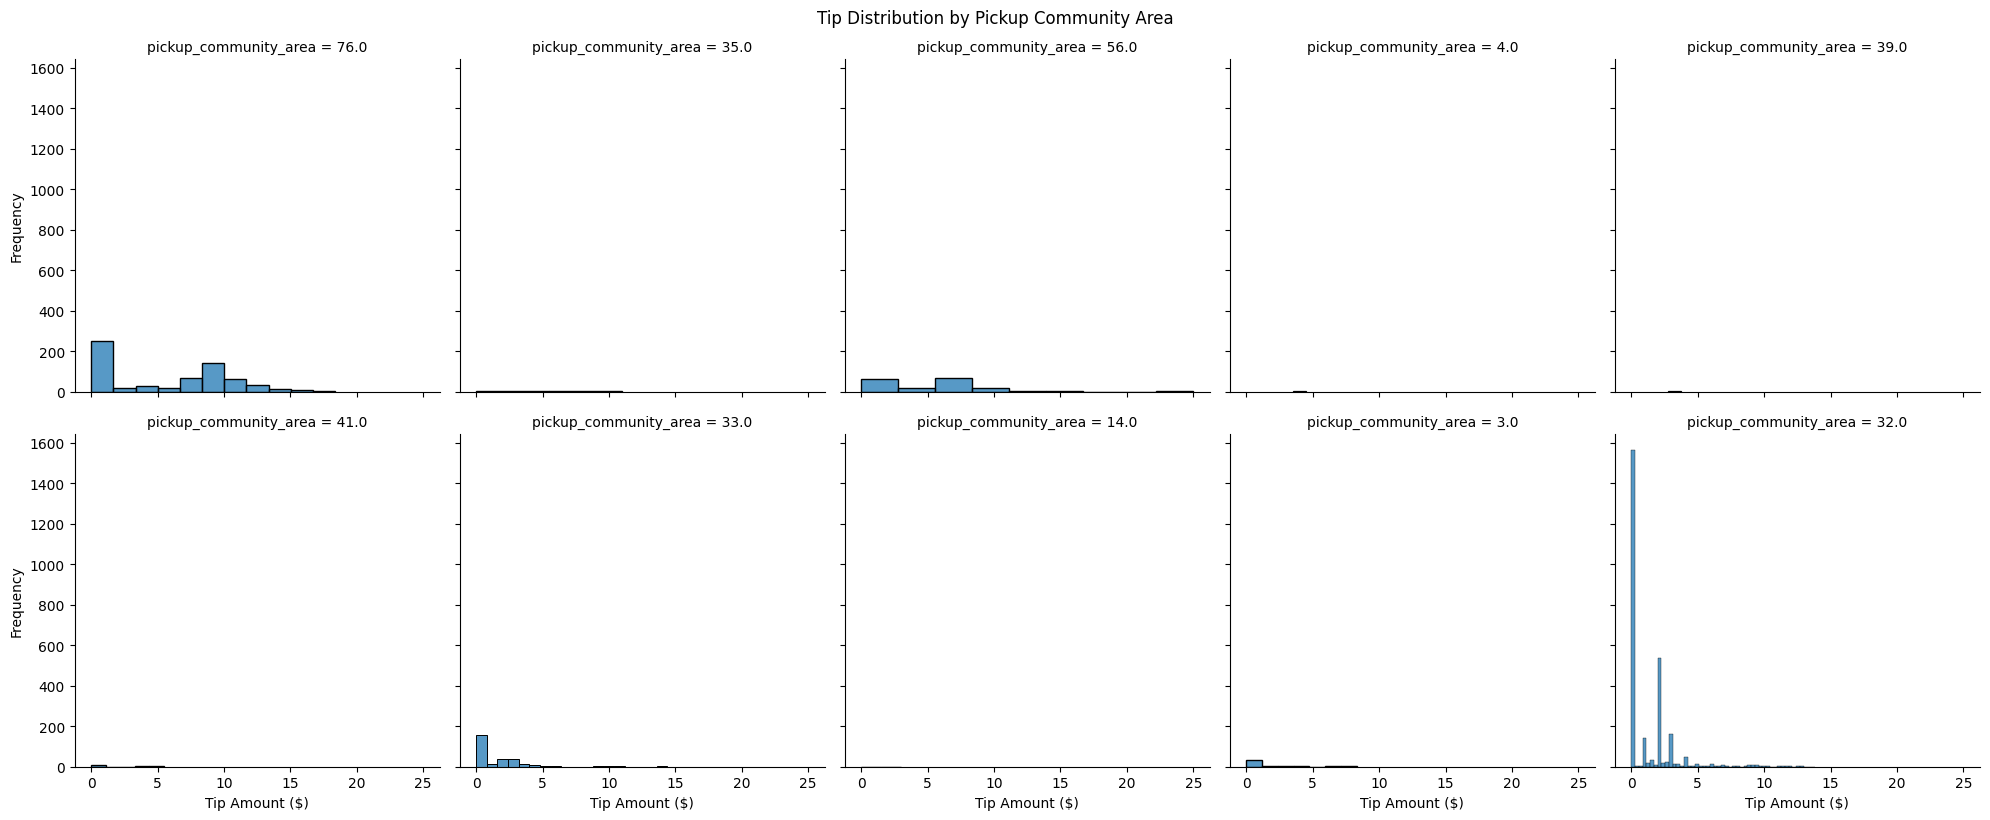

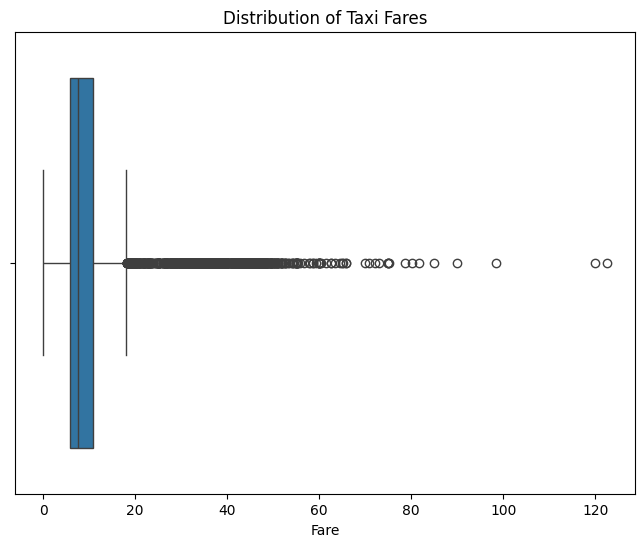

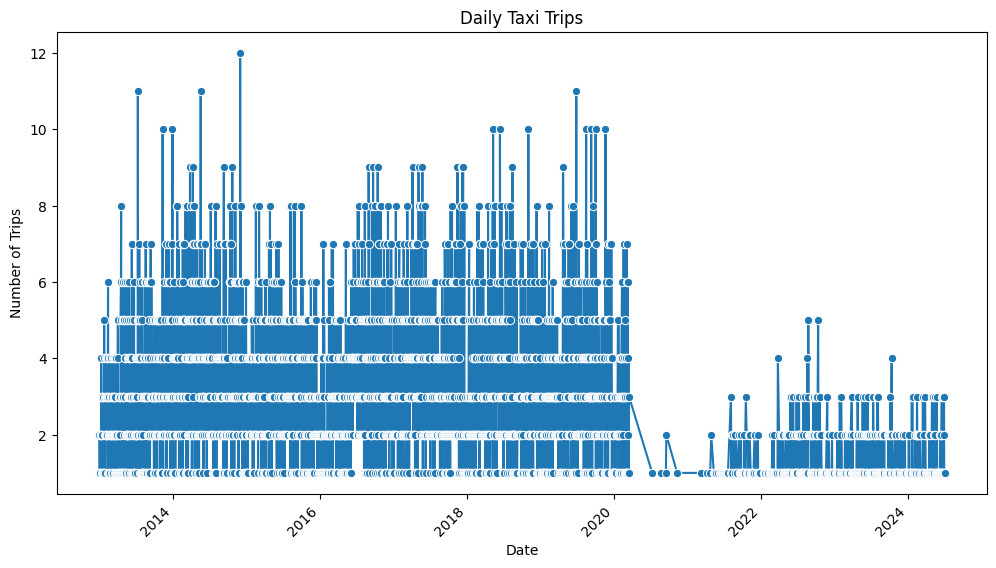

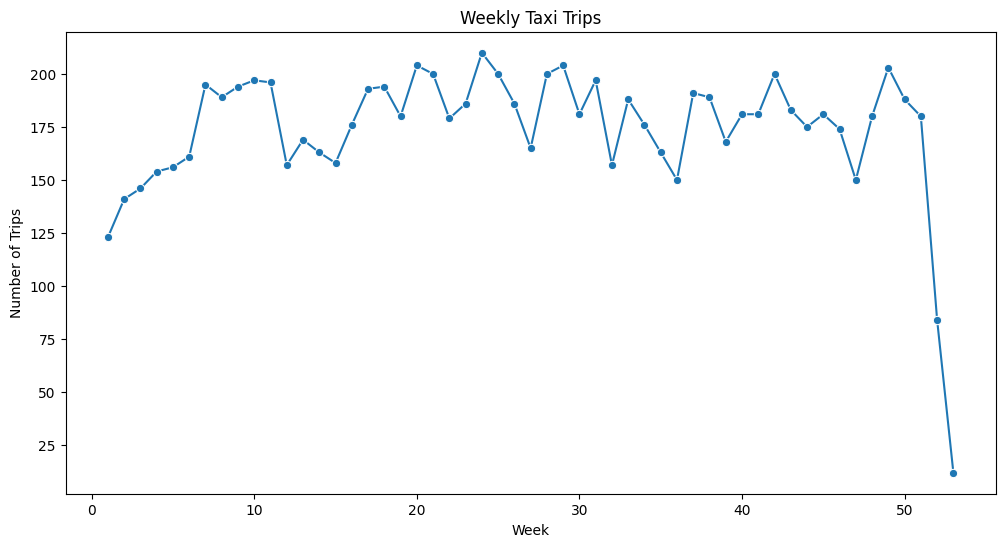

<ipython-input-2-04b531ff6be7>:166: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_trips = df['trip_start_timestamp'].dt.to_period('M').value_counts().sort_index()


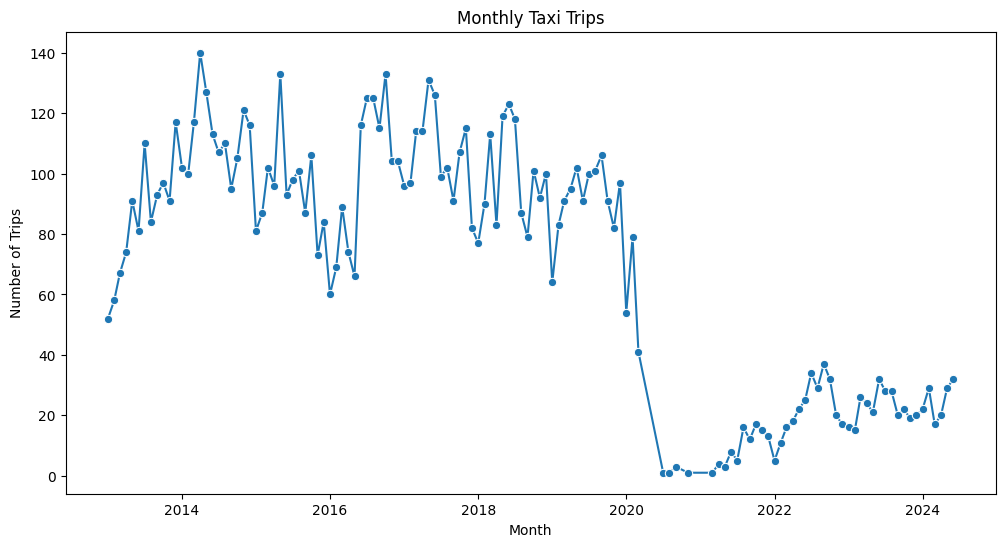

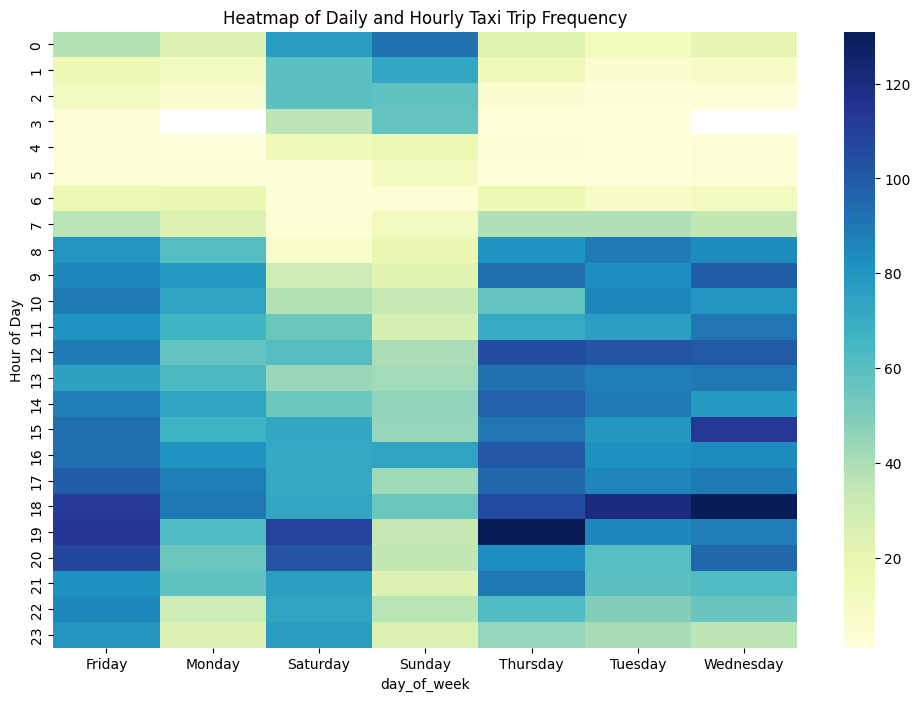

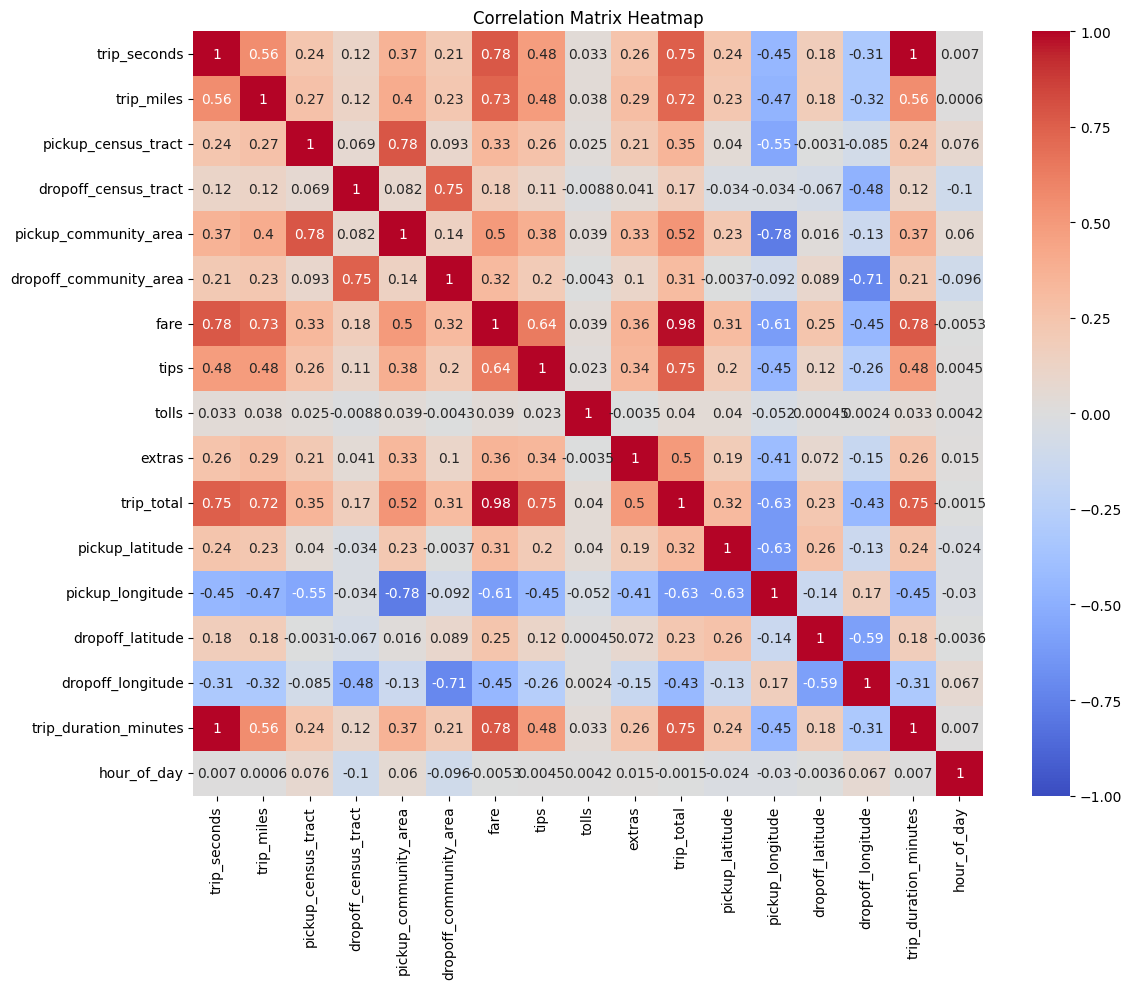


Basic Features Descriptive Statistics:
       trip_seconds   trip_miles  pickup_census_tract  dropoff_census_tract  \
count        9208.0  9208.000000          9208.000000           9208.000000   
mean     760.569179     2.567063             0.377505              0.368467   
std      841.946809     5.302574             0.352504              0.346084   
min             0.0     0.000000             0.000000              0.000208   
25%           360.0     0.000000             0.073124              0.073317   
50%           540.0     0.970000             0.279908              0.278202   
75%           840.0     1.890000             0.854579              0.848422   
max         37177.0   174.000000             1.000000              1.000000   

       pickup_community_area  dropoff_community_area         fare  \
count             9208.00000             9208.000000  9208.000000   
mean                24.14129               22.552237    11.796041   
std                 18.88368             

<Figure size 1200x1200 with 0 Axes>

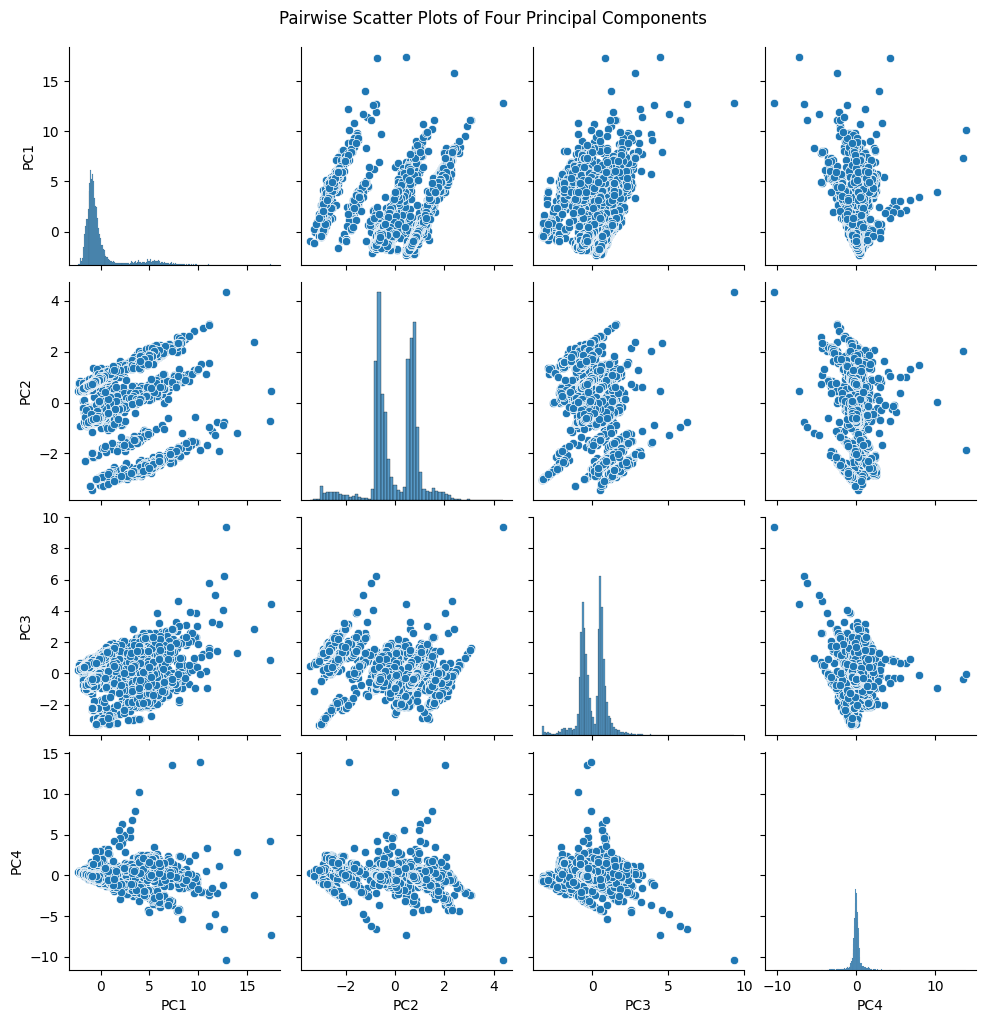

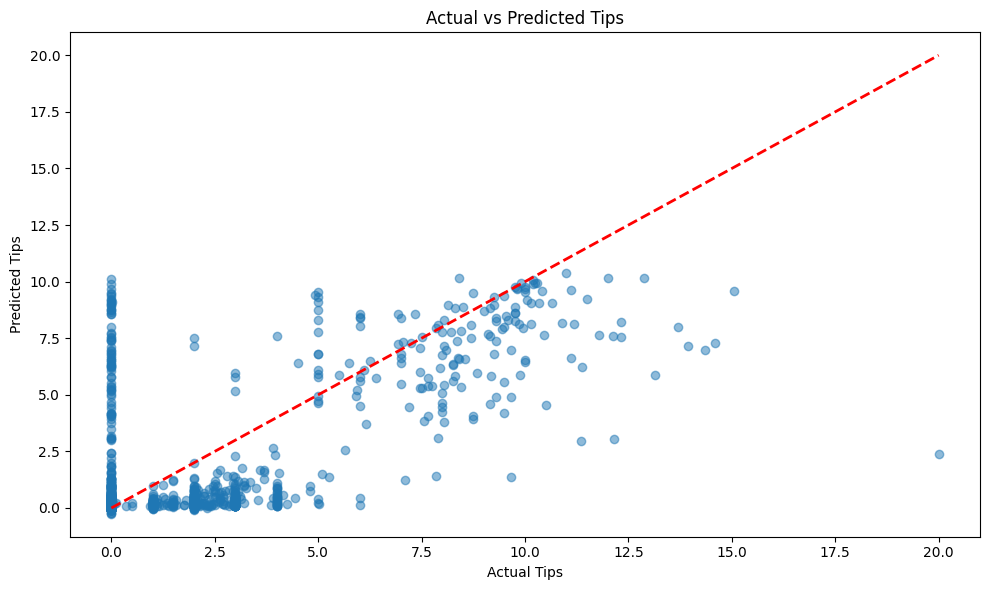

Mean Squared Error: 4.2803
Mean Absolute Error: 1.2042
Root Mean Squared Error: 2.0689
R-squared Score: 0.3678
Predictions within 40% of actual: 7.38%
Predictions within 50% of actual: 8.52%


In [2]:
# PART 1: SET UP AND FEATURE ENGINEERING

import pandas as pd
from google.cloud import bigquery
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

project_id = 'chicago-taxi-trips-427817'
dataset_id = 'chicago_taxi_trips'
table_id = 'taxi_trips'

# Construct a reference to the table
table_ref = bigquery.TableReference.from_string(f"{project_id}.{dataset_id}.{table_id}")

# Create a BigQuery client
client = bigquery.Client(project=project_id)

# Query to select a random sample
sample_percentage = 0.01  # 1% sample
query = f"""
    SELECT *
    FROM `{project_id}.{dataset_id}.{table_id}`
    WHERE RAND() < {sample_percentage / 100}
"""

# Read the sampled data into a DataFrame
df = client.query(query).to_dataframe()

df = df.copy()

#------

# Data Cleaning and Feature transformation/engineering

# Scale large value columns pickup and dropoff census tracts
scaler = MinMaxScaler()
df[['pickup_census_tract', 'dropoff_census_tract']] = scaler.fit_transform(df[['pickup_census_tract', 'dropoff_census_tract']])

# Scaling continued
def cap_extreme_values(df, columns, lower_percentile=0.0001, upper_percentile=0.9999):
    for col in columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            lower = df[col].quantile(lower_percentile)
            upper = df[col].quantile(upper_percentile)

            if pd.api.types.is_integer_dtype(df[col]):
                lower = int(lower)
                upper = int(upper)
                df[col] = df[col].clip(lower, upper).astype('Int64')
            else:
                df[col] = df[col].clip(lower, upper)
    return df

# Convert to correct data types
df['trip_start_timestamp'] = pd.to_datetime(df['trip_start_timestamp'])
df['trip_end_timestamp'] = pd.to_datetime(df['trip_end_timestamp'])
df['pickup_community_area'] = df['pickup_community_area'].astype(float)
df['dropoff_community_area'] = df['dropoff_community_area'].astype(float)

# Feature construction - making new features based on existing data
df['trip_duration_minutes'] = df['trip_seconds'] / 60

df = df.dropna()

# PART 2: DATA EXPLORATION, AND VISUALIZATION

# 1. Scatter plot of Fare vs. Miles

plt.figure(figsize=(10, 6))
sns.scatterplot(x='trip_miles', y='fare', data=df, alpha=0.5)
plt.title('Fare vs. Trip Distance')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Fare ($)')
plt.grid(axis='y', linestyle='--')
plt.show()

#########

# 2. Scatterplot of Tips vs. Fare

plt.figure(figsize=(10, 6))
sns.scatterplot(x='fare', y='tips', data=df, alpha=0.5)  # alpha for transparency
plt.title('Tip Amount vs. Fare')
plt.xlabel('Fare ($)')
plt.ylabel('Tip ($)')
plt.grid(axis='y', linestyle='--')
plt.show()

#########

# 3. Using faceting to show how tip amounts vary across different dropoff community areas

# Select top community areas and sort by average tip
top_dropoff_communities = df.groupby('dropoff_community_area')['tips'].mean().sort_values(ascending=False).head(10).index

# Filter the dataset for those communities
filtered_df = df[df['dropoff_community_area'].isin(top_dropoff_communities)]

# Create a faceted grid of histograms, explicitly specifying the order
grid = sns.FacetGrid(filtered_df, col="dropoff_community_area", col_wrap=5, height=4, col_order=top_dropoff_communities)
grid.map(sns.histplot, "tips")

# Add titles and labels
grid.fig.suptitle('Tip Distribution by Dropoff Community Area', y=1.02)
grid.set_axis_labels("Tip Amount ($)", "Frequency")
plt.show()

##########

# 4. Using faceting to show how tip amounts vary across different pickup community areas

# Select top community areas and sort by average tip
top_pickup_communities = df.groupby('pickup_community_area')['tips'].mean().sort_values(ascending=False).head(10).index

# Filter the dataset for those communities
filtered_df = df[df['pickup_community_area'].isin(top_pickup_communities)]

# Create a faceted grid of histograms, explicitly specifying the order
grid = sns.FacetGrid(filtered_df, col="pickup_community_area", col_wrap=5, height=4, col_order=top_pickup_communities)
grid.map(sns.histplot, "tips")

# Add titles and labels
grid.fig.suptitle('Tip Distribution by Pickup Community Area', y=1.02)
grid.set_axis_labels("Tip Amount ($)", "Frequency")
plt.show()

#######

# 5. # Trip Fares Boxplot


plt.figure(figsize=(8, 6))
sns.boxplot(x=df['fare'])
plt.title('Distribution of Taxi Fares')
plt.xlabel('Fare')
plt.show()

########

# 6. # Daily, Weekly, and Monthly line plots and a daily heatmap of trips taken

# Daily Trips
daily_trips = df['trip_start_timestamp'].dt.date.value_counts().sort_index()
plt.figure(figsize=(12, 6))
sns.lineplot(x=daily_trips.index, y=daily_trips.values, marker='o')
plt.title('Daily Taxi Trips')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45, ha='right')
plt.show()

# Weekly Trips
weekly_trips = df['trip_start_timestamp'].dt.isocalendar().week.value_counts().sort_index()
plt.figure(figsize=(12, 6))
sns.lineplot(x=weekly_trips.index, y=weekly_trips.values, marker='o')
plt.title('Weekly Taxi Trips')
plt.xlabel('Week')
plt.ylabel('Number of Trips')
plt.show()

# Monthly Trips
monthly_trips = df['trip_start_timestamp'].dt.to_period('M').value_counts().sort_index()
plt.figure(figsize=(12, 6))
sns.lineplot(x=monthly_trips.index.to_timestamp(), y=monthly_trips.values, marker='o')
plt.title('Monthly Taxi Trips')
plt.xlabel('Month')
plt.ylabel('Number of Trips')
plt.show()

# Daily Heatmap
df['day_of_week'] = df['trip_start_timestamp'].dt.day_name()
df['hour_of_day'] = df['trip_start_timestamp'].dt.hour

# Create a copy of the relevant columns to avoid the warning
heatmap_df = df[['hour_of_day', 'day_of_week']].copy()
heatmap_data = heatmap_df.pivot_table(index='hour_of_day', columns='day_of_week', aggfunc='size')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu')
plt.title('Heatmap of Daily and Hourly Taxi Trip Frequency')
plt.ylabel('Hour of Day')
plt.show()

#########

# 7. Correlation Heat Map

# Select numeric columns for correlation analysis
numeric_columns = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_columns].corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

#############

print("\nBasic Features Descriptive Statistics:")
print(df.describe())

#-------


# PART 3: FEATURE TRANSFORMATION

# Using PCA for Feature Extraction and Transformation

# Separate numeric features and entity ids
numeric_features = ['trip_miles', 'fare', 'trip_total', 'trip_seconds', 'pickup_community_area', 'dropoff_community_area', 'trip_duration_minutes']
entity_id_columns = ['taxi_id', 'unique_key']

df = cap_extreme_values(df, numeric_features) # cap extreme values

X = df[numeric_features]

# Check for any remaining null values
print(X.isnull().sum())

# Standardize
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_std)

# Pairwise scatter plots for all four components to show how each principal component relates to the others
plt.figure(figsize=(12, 12))
sns.pairplot(pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4']))
plt.suptitle('Pairwise Scatter Plots of Four Principal Components', y=1.02)
plt.show()

# PART 4: MODEL TRAINING AND EVALUATION

################## TENSOR FLOW MODEL ##################

# Uncomment and comment models accordingly based on what you want to run

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score
import numpy as np

# Prepare the features and target (renamed for comprehension)
features = ['trip_miles', 'fare', 'trip_total', 'trip_seconds', 'pickup_community_area',
            'dropoff_community_area', 'trip_duration_minutes']
# X = df[features]
X = X_pca # Use PCA transformed features for models
y = df['tips']

# Perform all feature engineering and scaling before model training
X_scaled = scaler.fit_transform(X)
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# # Keras Sequential Neural Network ---------

# # Define the model
# model = Sequential([
#     Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
#     Dropout(0.2),
#     Dense(32, activation='relu'),
#     Dropout(0.2),
#     Dense(16, activation='relu'),
#     Dense(1)  # Output layer
# ])


# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Train the model
# history = model.fit(
#     X_train_scaled, y_train,
#     epochs=20,
#     batch_size=64,
#     validation_split=0.2,
#     verbose=1
# )


# # Evaluate the model:

# # Make predictions
# y_pred = model.predict(X_test_scaled)

# # For the sequential model only:
# y_pred_flat = y_pred.flatten()
# y_test = y_test.values if isinstance(y_test, (pd.DataFrame, pd.Series)) else y_test

# # Visualize actual vs predicted values
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 6))
# plt.scatter(y_test, y_pred, alpha=0.5)
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
# plt.xlabel('Actual Tips')
# plt.ylabel('Predicted Tips')
# plt.title('Actual vs Predicted Tips')
# plt.tight_layout()
# plt.show()

# # Evaluate the model
# mse = mean_squared_error(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)
# rmse = np.sqrt(mse)
# r2 = r2_score(y_test, y_pred)

# print(f"Mean Squared Error: {mse:.4f}")
# print(f"Mean Absolute Error: {mae:.4f}")
# print(f"Root Mean Squared Error: {rmse:.4f}")
# print(f"R-squared Score: {r2:.4f}")

# # Evaluate accuracy of y_pred against y_test
# def custom_accuracy(y_true, y_pred_flat, tolerance_percentage=10):
#     """
#     Calculate the percentage of predictions that are within a certain percentage of the true value.

#     Args:
#     y_true: array-like of true values
#     y_pred: array-like of predicted values
#     tolerance_percentage: the percentage tolerance for a prediction to be considered correct

#     Returns:
#     float: the percentage of predictions within the tolerance
#     """
#     tolerance = tolerance_percentage / 100.0
#     within_tolerance = np.abs(y_true - y_pred_flat) <= (tolerance * np.abs(y_true))
#     return np.mean(within_tolerance) * 100

# # Use the function
# accuracy_40percent = custom_accuracy(y_test, y_pred, tolerance_percentage=40)
# accuracy_50percent = custom_accuracy(y_test, y_pred, tolerance_percentage=50)

# print(f"Predictions within 40% of actual: {accuracy_40percent:.2f}%")
# print(f"Predictions within 50% of actual: {accuracy_50percent:.2f}%")



# end sequential NN model -----------


# Start Gradient Boost Model ----------

# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# # Create and train the Gradient Boosting model
# gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
# gb_model.fit(X_train_scaled, y_train)

# # Make predictions
# y_pred = gb_model.predict(X_test_scaled)

# # Visualize actual vs predicted values
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 6))
# plt.scatter(y_test, y_pred, alpha=0.5)
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
# plt.xlabel('Actual Tips')
# plt.ylabel('Predicted Tips')
# plt.title('Actual vs Predicted Tips')
# plt.tight_layout()
# plt.show()

# # Evaluate the model
# mse = mean_squared_error(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)
# rmse = np.sqrt(mse)
# r2 = r2_score(y_test, y_pred)

# print(f"Mean Squared Error: {mse:.4f}")
# print(f"Mean Absolute Error: {mae:.4f}")
# print(f"Root Mean Squared Error: {rmse:.4f}")
# print(f"R-squared Score: {r2:.4f}")

# # Evaluate accuracy of y_pred against y_test
# def custom_accuracy(y_true, y_pred, tolerance_percentage=10):
#     """
#     Calculate the percentage of predictions that are within a certain percentage of the true value.

#     Args:
#     y_true: array-like of true values
#     y_pred: array-like of predicted values
#     tolerance_percentage: the percentage tolerance for a prediction to be considered correct

#     Returns:
#     float: the percentage of predictions within the tolerance
#     """
#     tolerance = tolerance_percentage / 100.0
#     within_tolerance = np.abs(y_true - y_pred) <= (tolerance * np.abs(y_true))
#     return np.mean(within_tolerance) * 100

# # Use the function
# accuracy_40percent = custom_accuracy(y_test, y_pred, tolerance_percentage=40)
# accuracy_50percent = custom_accuracy(y_test, y_pred, tolerance_percentage=50)

# print(f"Predictions within 40% of actual: {accuracy_40percent:.2f}%")
# print(f"Predictions within 50% of actual: {accuracy_50percent:.2f}%")

# End gradient boost model -------

# Start Support Vector Regression model ------------

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

# Create and train the SVR model
svr = SVR(C=1.0, epsilon=0.1, kernel='rbf')  # These values can be adjusted
svr.fit(X_train_scaled, y_train)

# Make predictions
y_pred = svr.predict(X_test_scaled)

# Visualize actual vs predicted values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Tips')
plt.ylabel('Predicted Tips')
plt.title('Actual vs Predicted Tips')
plt.tight_layout()
plt.show()

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared Score: {r2:.4f}")

# Evaluate accuracy of y_pred against y_test
def custom_accuracy(y_true, y_pred, tolerance_percentage=10):
    """
    Calculate the percentage of predictions that are within a certain percentage of the true value.

    Args:
    y_true: array-like of true values
    y_pred: array-like of predicted values
    tolerance_percentage: the percentage tolerance for a prediction to be considered correct

    Returns:
    float: the percentage of predictions within the tolerance
    """
    tolerance = tolerance_percentage / 100.0
    within_tolerance = np.abs(y_true - y_pred) <= (tolerance * np.abs(y_true))
    return np.mean(within_tolerance) * 100

# Use the function
accuracy_40percent = custom_accuracy(y_test, y_pred, tolerance_percentage=40)
accuracy_50percent = custom_accuracy(y_test, y_pred, tolerance_percentage=50)

print(f"Predictions within 40% of actual: {accuracy_40percent:.2f}%")
print(f"Predictions within 50% of actual: {accuracy_50percent:.2f}%")

# End support vector regression model ----

# Start Polynomial regression model -----------

# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.preprocessing import PolynomialFeatures, StandardScaler
# from sklearn.linear_model import LinearRegression
# from sklearn.pipeline import make_pipeline
# from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

# # Function to create and evaluate polynomial regression model
# def poly_regression(degree):
#     # Create a pipeline that scales, creates polynomial features, then fits a linear regression
#     model = make_pipeline(
#         StandardScaler(),
#         PolynomialFeatures(degree, include_bias=False),
#         LinearRegression()
#     )

#     # Fit the model
#     model.fit(X_train_scaled, y_train)

#     # Make predictions
#     y_pred = model.predict(X_test_scaled)

#     # Calculate metrics
#     mse = mean_squared_error(y_test, y_pred)
#     r2 = r2_score(y_test, y_pred)

#     # Perform cross-validation
#     cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
#     cv_mse = -cv_scores.mean()

#     return model, mse, r2, cv_mse, y_pred

# # Try different degrees of polynomial features
# degrees = [1, 2, 3, 4]
# results = []

# for degree in degrees:
#     model, mse, r2, cv_mse, y_pred = poly_regression(degree)
#     results.append({
#         'Degree': degree,
#         'Test MSE': mse,
#         'Test R2': r2,
#         'CV MSE': cv_mse
#     })
#     print(f"Degree {degree}:")
#     print(f"  Test MSE: {mse:.4f}")
#     print(f"  Test R2: {r2:.4f}")
#     print(f"  CV MSE: {cv_mse:.4f}")
#     print()

# # Convert results to DataFrame
# results_df = pd.DataFrame(results)

# # Select the best model (you can change the criterion as needed)
# best_degree = results_df.loc[results_df['CV MSE'].idxmin(), 'Degree']
# print(f"Best degree based on CV MSE: {best_degree}")

# # Fit the best model
# best_model, best_mse, best_r2, _, y_pred = poly_regression(best_degree)

# # Visualize actual vs predicted values
# plt.figure(figsize=(10, 6))
# plt.scatter(y_test, y_pred, alpha=0.5)
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
# plt.xlabel('Actual Tips')
# plt.ylabel('Predicted Tips')
# plt.title(f'Actual vs Predicted Tips (Polynomial Regression, Degree {best_degree})')
# plt.tight_layout()
# plt.show()

# # Evaluate the model
# mse = mean_squared_error(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)
# rmse = np.sqrt(mse)
# r2 = r2_score(y_test, y_pred)

# print(f"Mean Squared Error: {mse:.4f}")
# print(f"Mean Absolute Error: {mae:.4f}")
# print(f"Root Mean Squared Error: {rmse:.4f}")
# print(f"R-squared Score: {r2:.4f}")

# # Evaluate accuracy of y_pred against y_test
# def custom_accuracy(y_true, y_pred, tolerance_percentage=10):
#     """
#     Calculate the percentage of predictions that are within a certain percentage of the true value.

#     Args:
#     y_true: array-like of true values
#     y_pred: array-like of predicted values
#     tolerance_percentage: the percentage tolerance for a prediction to be considered correct

#     Returns:
#     float: the percentage of predictions within the tolerance
#     """
#     tolerance = tolerance_percentage / 100.0
#     within_tolerance = np.abs(y_true - y_pred) <= (tolerance * np.abs(y_true))
#     return np.mean(within_tolerance) * 100

# accuracy_40percent = custom_accuracy(y_test, y_pred, tolerance_percentage=40)
# accuracy_50percent = custom_accuracy(y_test, y_pred, tolerance_percentage=50)

# print(f"Predictions within 40% of actual: {accuracy_40percent:.2f}%")
# print(f"Predictions within 50% of actual: {accuracy_50percent:.2f}%")

# ------- end Polynomial regression model

################# Commented out feature storage for tensorflow demo 7/30 #################

# # PART 4: FEATURE STORAGE

# Save pca components into Vertex AI Feature Store for model training

#-----

# Create a feature view that uses the default service account and supports embeddings:
# https://cloud.google.com/vertex-ai/docs/featurestore/latest/create-featureview#create_featureview_bq_defaultsa
# Combining BiGuery and PCA with sample feature storage colab: https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/feature_store/online_feature_serving_and_fetching_bigquery_data_with_feature_store_bigtable.ipynb#scrollTo=XwY5CYLlBYAB

# from google.cloud import bigquery
# from google.cloud import aiplatform
# import vertexai
# from vertexai.resources.preview import feature_store
# from typing import List

# # Reference Doc: https://cloud.google.com/vertex-ai/docs/featurestore/latest/create-featureview#create_featureview_bq_defaultsa

# # Initialize Vertex AI
# project = 'chicago-taxi-trips-427817'
# location = 'us-central1'

# # Get or create a Bigtable Feature Online Store

# def get_or_create_bigtable_feature_online_store(
#     project: str,
#     location: str,
#     feature_online_store_id: str,
# ):
#     aiplatform.init(project=project, location=location)
#     try:
#         # Try to get the existing FeatureOnlineStore
#         fos = feature_store.FeatureOnlineStore(feature_online_store_id)
#         print(f"Retrieved existing FeatureOnlineStore: {fos.name}")
#     except exceptions.NotFound:
#         # If it doesn't exist, create a new one
#         fos = feature_store.FeatureOnlineStore.create_bigtable_store(
#             feature_online_store_id
#         )
#         print(f"Created new FeatureOnlineStore: {fos.name}")
#     return fos

# feature_online_store_id = "taxi_trip_online_store"
# fos = get_or_create_bigtable_feature_online_store(project, location, feature_online_store_id)

# # Storing PCA into a new table in BigQuery

# def store_pca_and_tips_in_bigquery(pca_df, project_id, dataset_id, table_id):
#     client = bigquery.Client(project=project_id)
#     table_ref = f"{project_id}.{dataset_id}.{table_id}"

#     # Define the schema
#     schema = [
#         bigquery.SchemaField("taxi_id", "STRING"),
#         bigquery.SchemaField("unique_key", "STRING"),
#         bigquery.SchemaField("pca_component_1", "FLOAT"),
#         bigquery.SchemaField("pca_component_2", "FLOAT"),
#         bigquery.SchemaField("pca_component_3", "FLOAT"),
#         bigquery.SchemaField("pca_component_4", "FLOAT"),
#         bigquery.SchemaField("tips", "FLOAT"),  # Add tips to feature store as well
#     ]

#     # Create a new table
#     table = bigquery.Table(table_ref, schema=schema)
#     table = client.create_table(table, exists_ok=True)  # This will create the table if it doesn't exist

#     # Load the data
#     job_config = bigquery.LoadJobConfig()
#     job_config.schema = schema
#     job = client.load_table_from_dataframe(pca_df, table_ref, job_config=job_config)
#     job.result()

#     print(f"PCA results stored in {table_ref}")

# # Function to create feature view from Big Query Source

# # Create dataframe of pca components
# pca_df = pd.DataFrame(
#     X_pca,
#     columns=['pca_component_1', 'pca_component_2', 'pca_component_3', 'pca_component_4']
# )
# # Add the identifiers back to pca_df
# for entity_id_column in entity_id_columns:
#     pca_df[entity_id_columns] = df[entity_id_columns]
# pca_df['tips'] = df['tips']  # Add tip amount back into pca df

# # # Store the PCA results in a new table
# # pca_table_id = 'pca_results'  # New table name
# # store_pca_in_bigquery(pca_df, project, dataset_id, pca_table_id)

# # Store the PCA results and the tips in a new table
# pca_table_id = 'pca_results_with_tips'  # New table name
# store_pca_and_tips_in_bigquery(pca_df, project, dataset_id, pca_table_id)

# bq_table_uri = f"bq://{project}.{dataset_id}.{pca_table_id}"
# # feature_view_id = "taxi_trip_pca_view"
# feature_view_id = "taxi_trip_pca_view_with_tips"

# print(vertexai.__version__)

# # Create a feature view that includes tip amount:
# def create_feature_view_from_bq_source(
#     project: str,
#     location: str,
#     feature_online_store_id: str,
#     feature_view_id: str,
#     bq_table_uri: str,
#     entity_id_columns: List[str],
# ):

#     aiplatform.init(project=project, location=location)

#     fos = feature_store.FeatureOnlineStore(feature_online_store_id)
#     feature_view = fos.create_feature_view(
#         name=feature_view_id,
#         source=feature_store.utils.FeatureViewBigQuerySource(
#             uri=bq_table_uri, entity_id_columns=entity_id_columns
#         ),
#     )
#     return feature_view

# # Create the feature view
# feature_view = create_feature_view_from_bq_source(
#     project=project,
#     location=location,
#     feature_online_store_id=feature_online_store_id,
#     feature_view_id=feature_view_id,
#     bq_table_uri=bq_table_uri,
#     entity_id_columns=["taxi_id", "unique_key"]
# )


# print(f"Feature View: {feature_view.name}")

# # Start ingestion (sync the feature view)
# feature_view.sync()





In [ ]:
# Part 4: Feature Extraction

# from google.cloud import aiplatform
# from vertexai.resources.preview import feature_store
# from vertexai.resources.preview.feature_store import (Feature, FeatureGroup, offline_store)
# from vertexai.resources.preview.feature_store import utils as fs_utils
# from google.cloud import bigquery
# import pandas as pd
# from typing import List, Union

# from google.cloud.aiplatform_v1beta1 import FeatureOnlineStoreServiceClient
# from google.cloud.aiplatform_v1beta1.types import feature_online_store_service as feature_online_store_service_pb2

# aiplatform.init(project=project_id, location=location)

# project_id = 'chicago-taxi-trips-427817'
# dataset_id = 'chicago_taxi_trips'
# table_id = 'taxi_trips'
# location_id = "us-central1"
# feature_online_store_id = "taxi_trip_online_store"
# feature_view_id = "taxi_trip_pca_view_with_tips"

# data_client = FeatureOnlineStoreServiceClient(
#   client_options={"api_endpoint": f"{location_id}-aiplatform.googleapis.com"}
# )

# feature_view = f"projects/{project_id}/locations/{location_id}/featureOnlineStores/{feature_online_store_id}/featureViews/{feature_view_id}"

# def get_random_entity_ids(project, dataset, table, num_samples=1000):
#     client = bigquery.Client(project=project)
#     query = f"""
#     SELECT DISTINCT taxi_id, unique_key
#     FROM `{project}.{dataset}.{table}`
#     ORDER BY RAND()
#     LIMIT {num_samples}
#     """
#     query_job = client.query(query)
#     results = query_job.result()
#     return [[row['taxi_id'], row['unique_key']] for row in results]

# def extract_features_and_tips(data_client, feature_view, project, dataset, table, num_samples=1000):
#     # Get a sample of entity IDs
#     keys_list = get_random_entity_ids(project, dataset, table, num_samples)

#     requests = []

#     for keys in keys_list:
#         requests.append(
#             feature_online_store_service_pb2.StreamingFetchFeatureValuesRequest(
#                 feature_view=feature_view,
#                 data_keys=[
#                     feature_online_store_service_pb2.FeatureViewDataKey(key=key)
#                     for key in keys
#                 ]
#             )
#         )

#     responses = data_client.streaming_fetch_feature_values(
#         requests=iter(requests)
#     )

#     # Process responses
#     feature_data = []
#     for response in responses:
#         # Print the structure of the response for debugging
#         print("Response structure:", response)

#         entity_data = {}
#         # Adjust this part based on the actual structure of the response
#         for feature in response.features:
#             entity_data[feature.name] = feature.value.double_value
#         feature_data.append(entity_data)

#     # Convert to DataFrame
#     df = pd.DataFrame(feature_data)

#     # Separate features (PCA components) and target (tips)
#     feature_columns = [col for col in df.columns if col.startswith('pca_component_')]
#     X = df[feature_columns]
#     y = df['tips']

#     return X, y

# X, y = extract_features_and_tips(data_client, feature_view, project_id, dataset_id, table_id)

# print("Features shape:", X.shape)
# print("Tips shape:", y.shape)
# print("\nFeature columns:", X.columns)
# print("\nFirst few rows of features:")
# print(X.head())
# print("\nFirst few tip values:")
# print(y.head())

